No handles with labels found to put in legend.


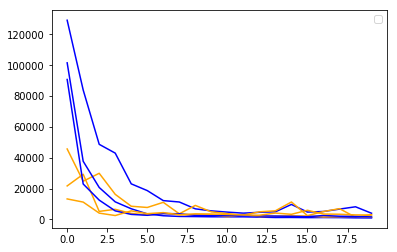

(8, 4, 1)
cnn: [40.548] 13.5, 53.8, 46.0, 37.2
40.54804158967252 [13.522153532005296, 53.82588663819169, 45.96317109418932, 37.200625432877615]


No handles with labels found to put in legend.


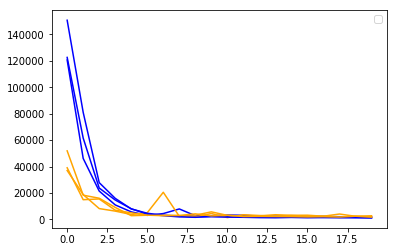

(9, 4, 1)
cnn: [40.506] 17.0, 50.9, 44.9, 40.8
40.50630948875048 [17.029556851265035, 50.86200933058704, 44.94661398458833, 40.815395476890565]


No handles with labels found to put in legend.


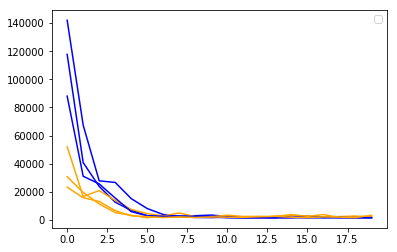

(10, 4, 1)
cnn: [40.455] 21.2, 50.6, 45.3, 38.6
40.4554318698174 [21.208826838580215, 50.56562493901242, 45.26360526482078, 38.61447013306421]


No handles with labels found to put in legend.


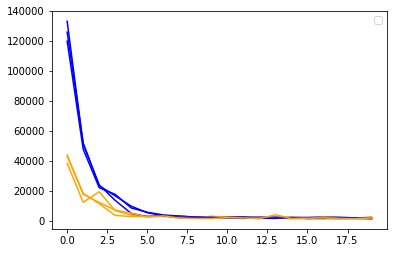

(11, 4, 1)
cnn: [35.373] 16.9, 45.7, 39.9, 32.3
35.373481637025776 [16.86166685935692, 45.652042970233396, 39.90671851820791, 32.31349343969904]


No handles with labels found to put in legend.


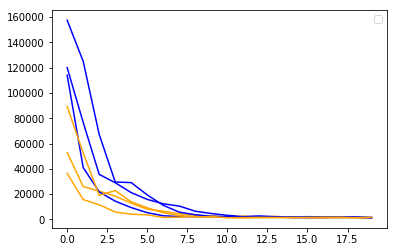

(12, 4, 1)
cnn: [33.178] 16.7, 40.9, 37.6, 32.2
33.17839152313596 [16.687784224605718, 40.91844768915444, 37.606233589582345, 32.18993499183163]


No handles with labels found to put in legend.


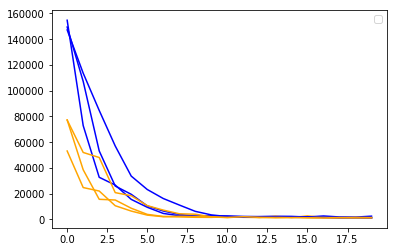

(13, 4, 1)
cnn: [40.447] 18.8, 47.5, 45.4, 43.2
40.44662613160321 [18.812073809940625, 47.50960332169732, 45.423052074960815, 43.23664950766893]


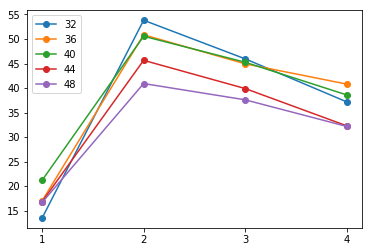

           0          1          2          3
0  13.522154  53.825887  45.963171  37.200625
1  17.029557  50.862009  44.946614  40.815395
2  21.208827  50.565625  45.263605  38.614470
3  16.861667  45.652043  39.906719  32.313493
4  16.687784  40.918448  37.606234  32.189935
5  18.812074  47.509603  45.423052  43.236650


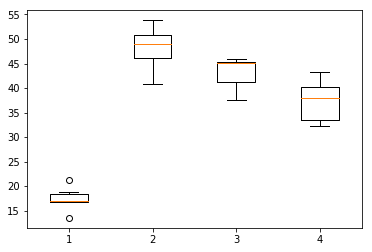

In [3]:
# univariate multi-step encoder-decoder lstm for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from pandas import DataFrame
import pandas as pd
from keras import optimizers
import keras.backend as K
import numpy as np

# split a univariate dataset into train/test sets
def split_dataset(data,n):
	# split into standard weeks
	train, test = data[0:-n], data[-n:]    
	train = array(split(train, len(train)/4))
	test = array(split(test, len(test)/4))    
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	mae_scores = list()      
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		mae = mean_absolute_error(actual[:, i], predicted[:, i])            
		# store
		scores.append(rmse)
		mae_scores.append(mae)        
	# calculate overall RMSE
	s = 0
	rmse_=DataFrame(scores)           
	mae_=DataFrame(mae_scores)    
	sonuc=pd.concat([rmse_, mae_], axis=1, ignore_index=True)        
	export_sonuc= sonuc.to_excel (r'C:\Users\sezgi.sener\Desktop\New folder\deep_learning_time_series_forecasting\code\chapter_20\encoder_decoder_lstm_sonuc.xlsx', index = None, header=True)        
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=4):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, test,n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	test_x, test_y = to_supervised(test, n_input)    
	# define parameters
	verbose, epochs, batch_size = 0, 20,len(batch_size)
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))      
	# define model
	# fit network
	repeats=3
	for i in range(repeats):
		model = Sequential()
		model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
		model.add(RepeatVector(n_outputs))
		model.add(LSTM(200, activation='relu', return_sequences=True))
		model.add(TimeDistributed(Dense(100, activation='relu')))
		model.add(TimeDistributed(Dense(1)))    
		model.compile(loss='mse', optimizer='adam', metrics=['mse','accuracy','mape'])          
		aa=model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size,validation_data=(test_x, test_y), verbose=verbose) 
		pyplot.plot(aa.history['loss'],  color='blue')
		pyplot.plot(aa.history['val_loss'], color='orange')
		#print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, xx.history['loss'].iloc[-1], xx.history['val_loss'].iloc[-1]))
		model.reset_states() 
		#model.layers[1].reset_states()
		#reset_weights(model)         
	pyplot.savefig('epochs_diagnostic_diff_lstm.png')   
	pyplot.legend()
	pyplot.show()          
	# fit network
	plot_model(model, show_shapes=True, to_file='encoder_decoder_lstm.png')     
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train,test, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	print(predictions.shape) 
	pred=pd.DataFrame(predictions.reshape(predictions.shape[0],predictions.shape[1]))   
	test_=pd.DataFrame(test[:,:,0])    
	pred=pd.concat([pred, test_], axis=1, ignore_index=True)
	export_pred = pred.to_excel (r'C:\Users\sezgi.sener\Desktop\New folder\deep_learning_time_series_forecasting\code\chapter_20\encoder_decoder_lstm_predictions.xlsx', index = None, header=True)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

# load the new file
dataset = read_csv('MyData_weeks.csv', header=0, infer_datetime_format=True, 
                   parse_dates=['Weeks'], index_col=['Weeks'])# split into train and test
# split into train and test
son = list()
for n in [8,9,10,11,12,13]:
	#print(n)    
	train, test = split_dataset(dataset.values,n*4)
	# define the names and functions for the models we wish to evaluate
	n_input = 12
	score, scores = evaluate_model(train, test, n_input)
	# summarize scores
	summarize_scores('cnn', score, scores)
	# evaluate each model
	print(score,scores)
	son.append(scores)
weeks = ['1', '2', '3', '4']
a=0
for i in [8,9,10,11,12]:
	pyplot.plot(weeks, DataFrame(son).T[a], marker='o', label=i*4)   
	a=a+1    
pyplot.savefig('multistep_encoder_lstm.png',show_shapes=True, show_layer_names=True) 
pyplot.legend()
pyplot.show()
print(DataFrame(son))
pyplot.boxplot(DataFrame(son).T)
pyplot.show()